# 目的
- 家のPriceを予測すること
- ８１の特徴量があるが、それをどう料理するかはKaggle参加者に任されている。
- 個人課題：学習モデルを複数用いて、回帰問題をエンドツーエンドで説明できるようにはしたい（課題があれば課題も書いておく）

# Importしましょう

In [357]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from sklearn import ensemble, metrics
from sklearn import linear_model, preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# CSVの中身を引っ張りましょう

In [358]:
#desc = pd.read_csv("./data_description.txt")
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv")

# 中身を眺めましょう

## Trainのほうです

In [359]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [360]:
train.shape

(1460, 81)

## Testのほうです

In [361]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [362]:
test.shape

(1459, 80)

## Submissionのほうです

In [363]:
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


# Trainデータを知りましょう

## Train データの特徴量の情報を知ります

In [364]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Sales priceの分布を確認します

avr=180921.195890, sigma=79415.29
skew=0.12122191311528359


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


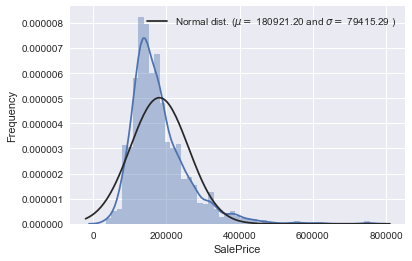

In [365]:
sns.distplot(train['SalePrice'], fit=norm)
avr, sigma = norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(avr, sigma)], loc='best')
plt.ylabel('Frequency')
print('avr={:2f}, sigma={:.2f}'.format(avr,sigma))
print('skew={}'.format(skew(np.log1p(train['SalePrice']))))

## 数値データだけでとりあえず平均とか最低とか最高をとって見ます

In [366]:
train.describe(include=['number']).loc[["mean","min","max"]]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
mean,730.5,56.89726,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.95411,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.19589
min,1.0,20.00000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.00000
max,1460.0,190.00000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.00000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.00000


## カテゴリカルデータだけでSales Priceを説明しているものを確認します

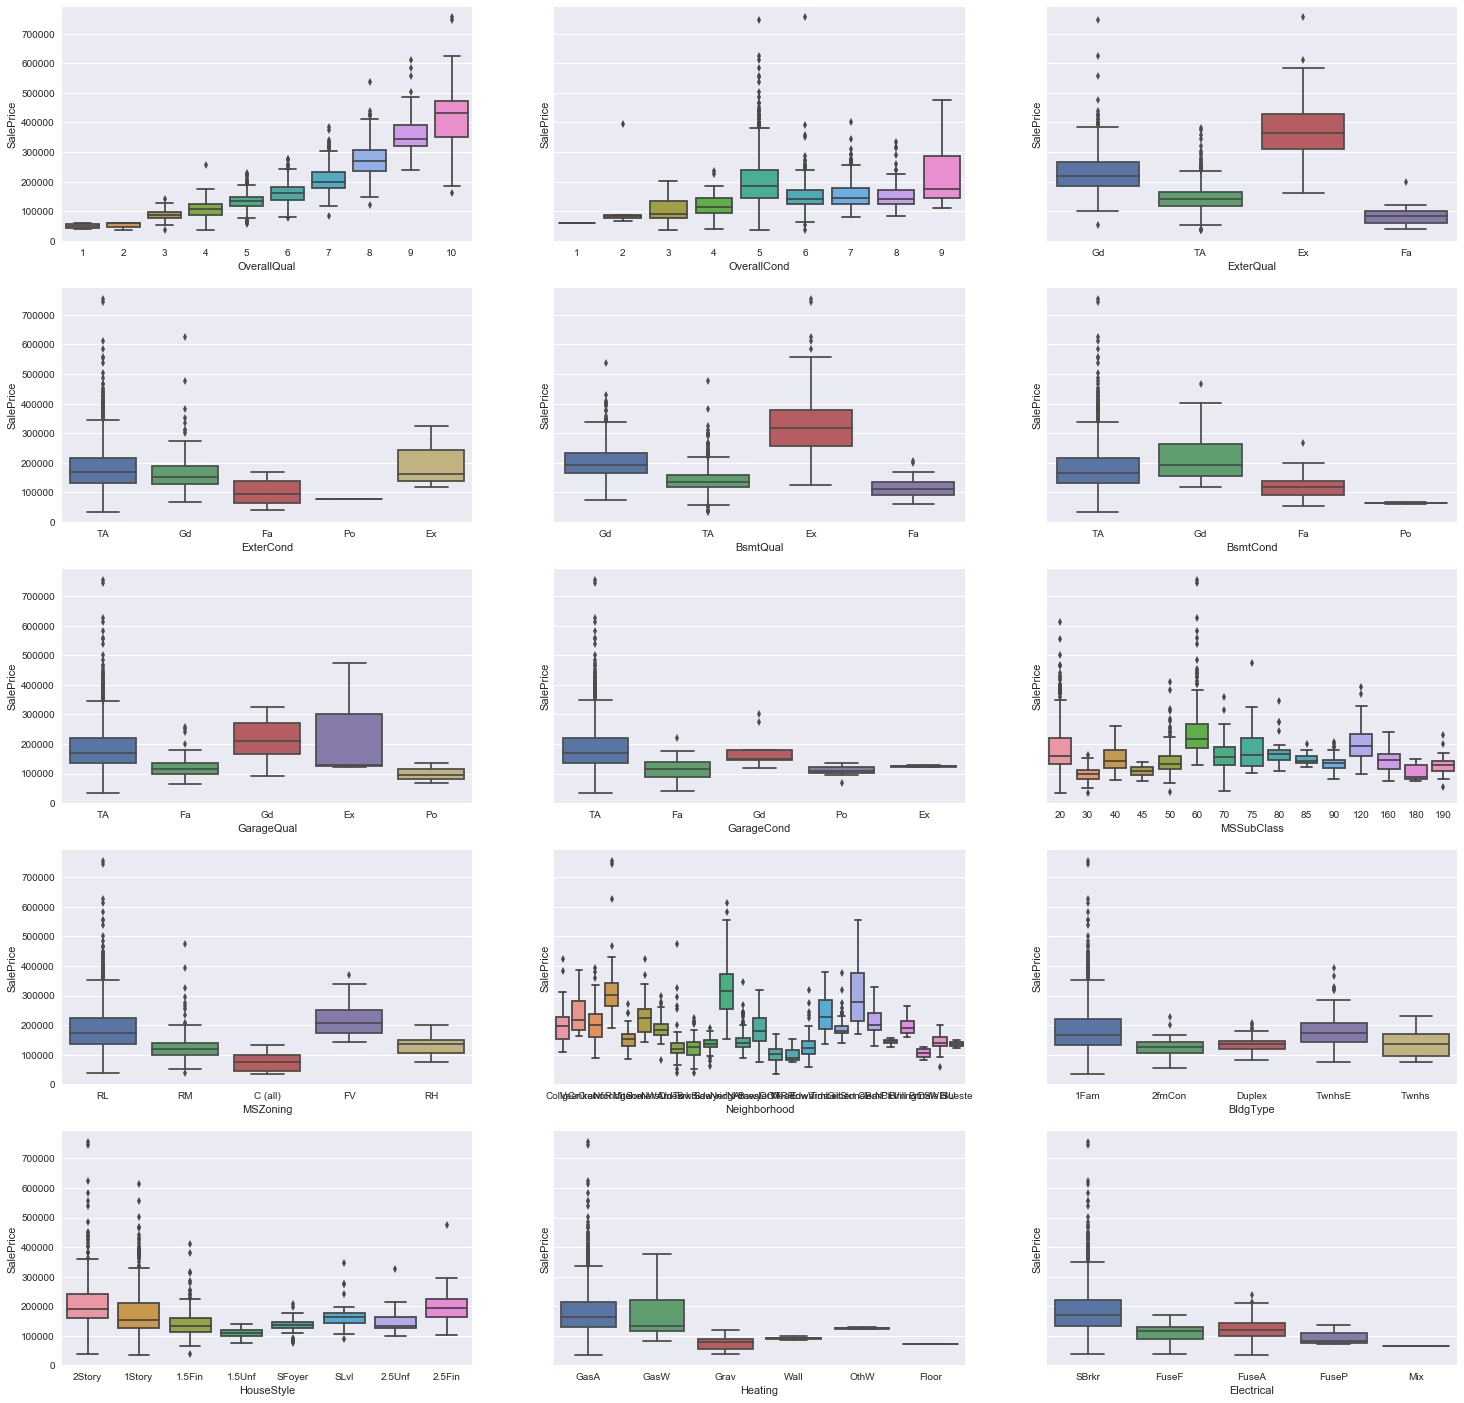

In [367]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(5 * 5, 5 * 5), sharey=True)
axes = np.ravel(axes)
cols = ['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond',
        'MSSubClass','MSZoning','Neighborhood','BldgType','HouseStyle','Heating','Electrical','SaleType']
for i, c in zip(np.arange(len(axes)), cols):
    sns.boxplot(x=c, y='SalePrice', data=train, ax=axes[i])

# 前処理

前処理の方針：Trainデータだけで８１特徴量あり、またTestデータが別のIDで存在していると考えられたため、Mergeすることにして、トレーニングとテストで同じ条件で使えるデータを増やす。とくにテストデータでも同じ条件で使いたいため。

## TrainとTestデータを組み合わせます

In [368]:

# reset_indexのなかのdrop=Trueを使うことで、前の特徴のNamingを踏襲する。
train_test = train.append(test).reset_index(drop=True)
train_test.shape

(2919, 81)

In [369]:
train_test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


## 数値データをカテゴリカルデータに変更する。

In [370]:
# to categorical feature
cols = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for c in cols:
    train_test[c] = train_test[c].astype(str)

## 品質系データのNAを０に置き換え、グレードデータに置き換える

In [371]:
# encode quality
# Ex(Excellent), Gd（Good）, TA（Typical/Average）, Fa（Fair）, Po（Poor）
cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
for c in cols:
    train_test[c].fillna(0, inplace=True)
    train_test[c].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

##   欠損値の研究

### 欠損に対する処理をします

In [372]:
def group_to_dummies(df, col1, col2, prefix):
    d_1 = pd.get_dummies(df[col1].astype(str), prefix=prefix)
    d_2 = pd.get_dummies(df[col2].astype(str), prefix=prefix)
    for c in list(set(list(d_1.columns) + list(d_2.columns))):
        if not c in d_1.columns: d_1[c] = 0
        if not c in d_2.columns: d_2[c] = 0
    return (d_1 + d_2).clip(0, 1)

cond = group_to_dummies(train_test,'Condition1','Condition2','Condition')
exterior = group_to_dummies(train_test,'Exterior1st','Exterior2nd','Exterior')
bsmtftype = group_to_dummies(train_test,'BsmtFinType1','BsmtFinType2','BsmtFinType') 

# dummy group を落とす
train_test = pd.concat([train_test, cond, exterior, bsmtftype], axis=1)
train_test.drop(['Condition1','Condition2', 'Exterior1st','Exterior2nd','BsmtFinType1','BsmtFinType2'], axis=1, inplace=True)
train_test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,Exterior_Wd Shng,Exterior_WdShing,Exterior_nan,BsmtFinType_ALQ,BsmtFinType_BLQ,BsmtFinType_GLQ,BsmtFinType_LwQ,BsmtFinType_Rec,BsmtFinType_Unf,BsmtFinType_nan
0,856,854,0,NaN,3,1Fam,3,No,706.0,0.0,...,0,0,0,0,0,1,0,0,1,0
1,1262,0,0,NaN,3,1Fam,3,Gd,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,920,866,0,NaN,3,1Fam,3,Mn,486.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,961,756,0,NaN,3,1Fam,4,No,216.0,0.0,...,1,0,0,1,0,0,0,0,1,0
4,1145,1053,0,NaN,4,1Fam,3,Av,655.0,0.0,...,0,0,0,0,0,1,0,0,1,0


### 欠損しているか目でも確認しましょう

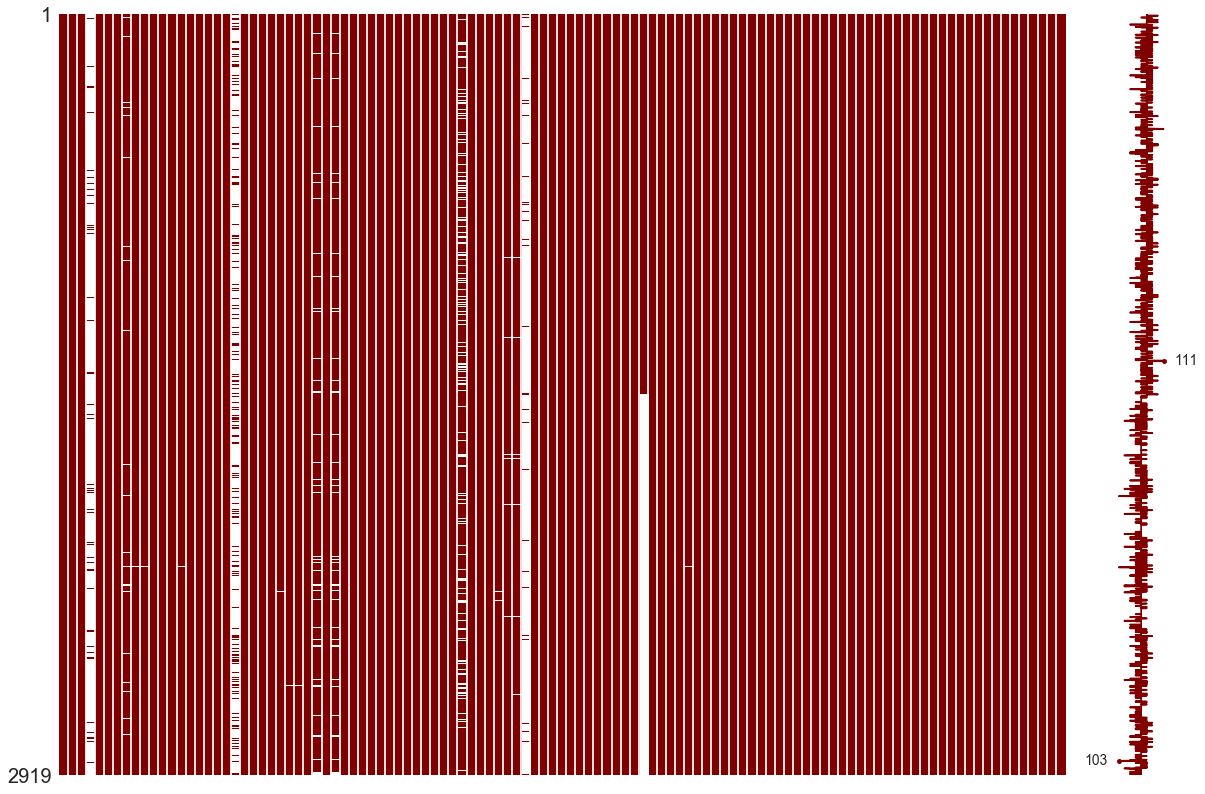

In [373]:
import missingno as msno
msno.matrix(df=train_test, figsize=(20,14), color=(0.5,0,0))

In [374]:
print(train_test.isnull().sum())

1stFlrSF               0
2ndFlrSF               0
3SsnPorch              0
Alley               2721
BedroomAbvGr           0
BldgType               0
BsmtCond               0
BsmtExposure          82
BsmtFinSF1             1
BsmtFinSF2             1
BsmtFullBath           0
BsmtHalfBath           0
BsmtQual               0
BsmtUnfSF              1
CentralAir             0
Electrical             1
EnclosedPorch          0
ExterCond              0
ExterQual              0
Fence               2348
FireplaceQu            0
Fireplaces             0
Foundation             0
FullBath               0
Functional             2
GarageArea             1
GarageCars             1
GarageCond             0
GarageFinish         159
GarageQual             0
                    ... 
Condition_RRAn         0
Condition_RRNe         0
Condition_RRNn         0
Exterior_AsbShng       0
Exterior_AsphShn       0
Exterior_Brk Cmn       0
Exterior_BrkComm       0
Exterior_BrkFace       0
Exterior_CBlock        0


### SalesをDropし、欠損をランキングしましょう

In [375]:
n = train_test.drop('SalePrice', axis=1).loc[:,train_test.isnull().any()].isnull().sum()
print(n.sort_values(ascending=False))

MiscFeature     2814
Alley           2721
Fence           2348
LotFrontage      486
GarageFinish     159
GarageType       157
BsmtExposure      82
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
Utilities          2
GarageArea         1
TotalBsmtSF        1
Electrical         1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
GarageCars         1
dtype: int64


### 欠損高いやつはNone

In [376]:
# fillna
for c in ['MiscFeature', 'Alley', 'Fence']:
    train_test[c].fillna('None', inplace=True)
    


### 数百の欠損については近いデータにGroupingするものとNAに0を代入する

In [377]:
train_test['LotFrontage'] = train_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train_test['GarageType'].fillna('None', inplace=True)
train_test['GarageFinish'].fillna(0, inplace=True)




### ガレージと建物の年を一致させる

In [378]:
train_test.loc[train_test.GarageYrBlt.isnull(),'GarageYrBlt'] = train_test.loc[train_test.GarageYrBlt.isnull(),'YearBuilt']

for c in ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    train_test[c].fillna(0, inplace=True)

### Sales PriceのNANのところに中央値を代入する

In [379]:
#Sales Price以外を順に読み込んで、そのままだす、
for i, t in train_test.loc[:, train_test.columns != 'SalePrice'].dtypes.iteritems():
    if t == object:
        train_test[i].fillna(train_test[i].mode()[0], inplace=True)
        train_test[i] = LabelEncoder().fit_transform(train_test[i].astype(str))
    else:
        train_test[i].fillna(train_test[i].median(), inplace=True)

###  再度目でもチェック( 元がTestのところは、欠損になっているはず）

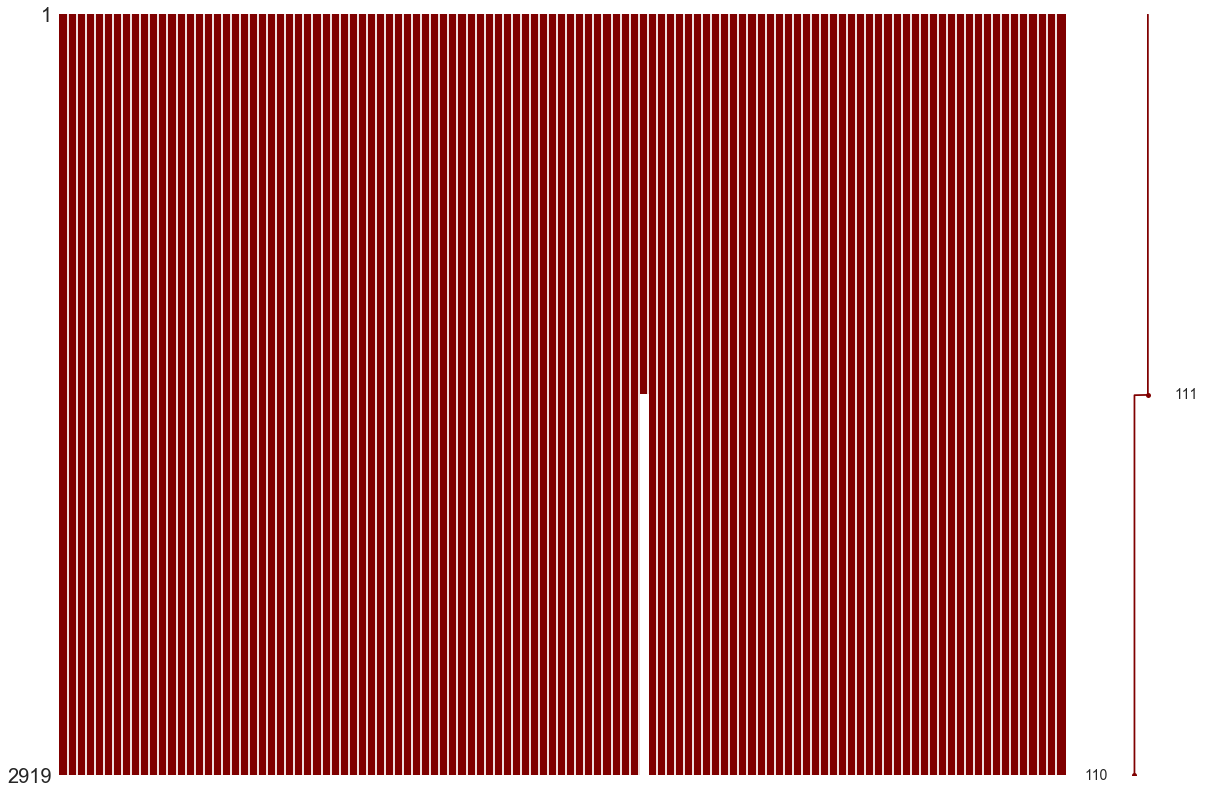

In [380]:
import missingno as msno
msno.matrix(df=train_test, figsize=(20,14), color=(0.5,0,0))

## 特徴量の追加を図る

### 何階あるか知る

In [381]:
train_test['TotalSF'] = train_test['TotalBsmtSF'] + train_test['1stFlrSF'] + train_test['2ndFlrSF']

### 満足データを面積にする（Ov.Qual=材質と仕上げへの満足度 * Ov.Cond=家のコンディションの満足度）

In [382]:
train_test['OverallQualCond'] = train_test['OverallQual'] * train_test['OverallCond']

### 満足データを立体にする（家全体満足指標（Ov.QualCond  * 階層数））

In [383]:
train_test['Interaction'] = train_test['TotalSF'] * train_test['OverallQual']

## インスタンスを準備する

### notnullになっている部分をtrain1とする

In [384]:
train1 = train_test[train_test['SalePrice'].notnull()]

### isnull になっている部分をtestt1 として、そのインスタンスからSalesPrice行を取り除く

In [385]:
test1 = train_test[train_test['SalePrice'].isnull()].drop('SalePrice', axis=1)

## 外れ値の研究

外れ値への方針：外れ値を見つけるために、とりあえずSales Priceに相関がありそうなものをまず知って、そこの部分だけ外れ値をなくす処理をする方針です

In [386]:
corr = train1.corr()
corr_price_abs = pd.DataFrame(corr.SalePrice.abs().sort_values(ascending=False))
for i, c in zip(np.arange(len(corr_price_abs)), corr_price_abs.index): print(i, ':', c)


0 : SalePrice
1 : Interaction
2 : OverallQual
3 : TotalSF
4 : GrLivArea
5 : ExterQual
6 : KitchenQual
7 : GarageCars
8 : GarageArea
9 : TotalBsmtSF
10 : 1stFlrSF
11 : BsmtQual
12 : OverallQualCond
13 : FullBath
14 : TotRmsAbvGrd
15 : YearBuilt
16 : FireplaceQu
17 : YearRemodAdd
18 : MasVnrArea
19 : Fireplaces
20 : BsmtFinType_GLQ
21 : HeatingQC
22 : GarageType
23 : BsmtFinSF1
24 : Foundation
25 : GarageYrBlt
26 : LotFrontage
27 : WoodDeckSF
28 : 2ndFlrSF
29 : OpenPorchSF
30 : Exterior_VinylSd
31 : BsmtExposure
32 : GarageFinish
33 : HalfBath
34 : GarageQual
35 : LotArea
36 : GarageCond
37 : LotShape
38 : CentralAir
39 : Electrical
40 : PavedDrive
41 : BsmtFullBath
42 : RoofStyle
43 : BsmtUnfSF
44 : SaleCondition
45 : BsmtCond
46 : Neighborhood
47 : HouseStyle
48 : Exterior_MetalSd
49 : BedroomAbvGr
50 : MSZoning
51 : Exterior_Wd Sdng
52 : BsmtFinType_BLQ
53 : BsmtFinType_nan
54 : Fence
55 : BsmtFinType_Rec
56 : KitchenAbvGr
57 : Exterior_CemntBd
58 : RoofMatl
59 : EnclosedPorch
60 : Ex

### 外れ値を除くやつを目で選びます

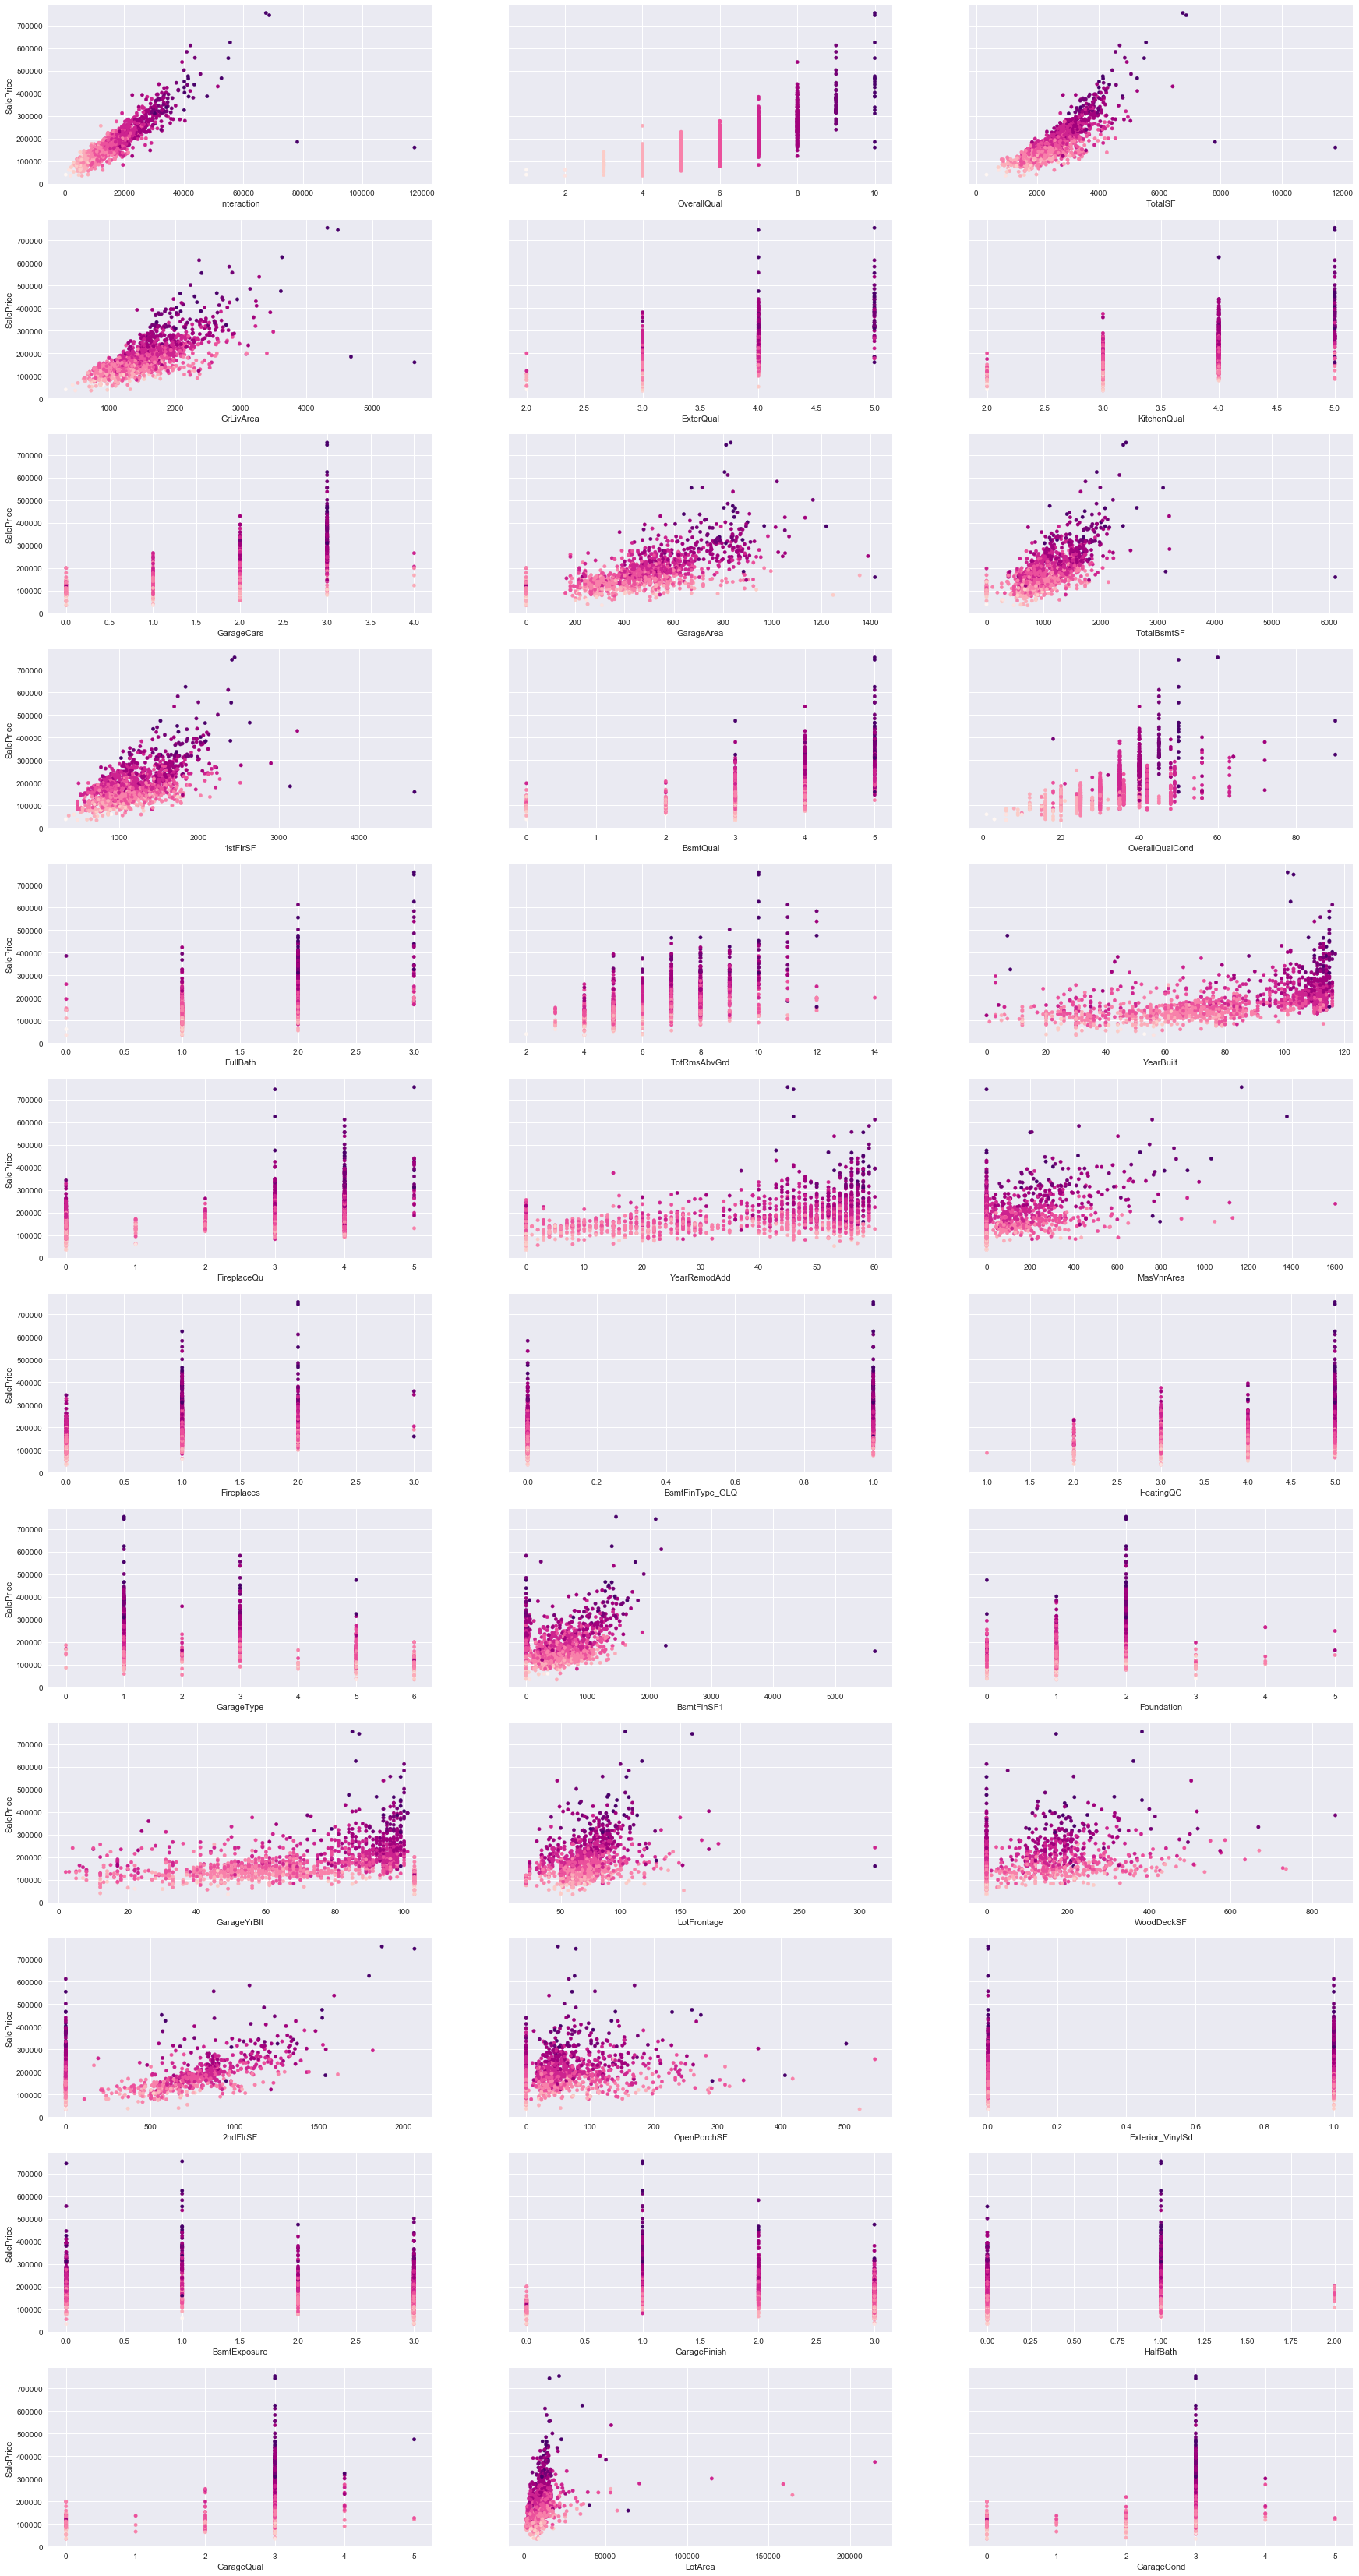

In [387]:
fig, axes = plt.subplots(ncols=3, nrows=12, figsize=(30, 60))
axes = np.ravel(axes)
col_name = corr_price_abs[1:].index
for i in range(36):
    train1.plot.scatter(ax=axes[i], x=col_name[i], y='SalePrice', c='OverallQual', sharey=True, colorbar=False, cmap='RdPu')

### TotalSFとSales Priceの高いやつ

In [388]:
# TotalSFの外れ値を外す
train1 = train1[train1['TotalSF'] < 6000]

In [389]:
# TotalBsmtSF の外れ値を外す
train1 = train[train['TotalBsmtSF'] < 4000]

In [390]:
# 本当に高い２件を除く
train1 = train[train['SalePrice'] < 700000]

###  内容を確認します

In [391]:
train1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [392]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
Id               1458 non-null int64
MSSubClass       1458 non-null int64
MSZoning         1458 non-null object
LotFrontage      1199 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            91 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1458 non-n

###  数値データに変更するよ

In [393]:
#　カラムの中を見て２変数だったらラベルエンコーダーにして&それ以外はワンホットエンコーダーする構文

from sklearn import preprocessing

train1_encoded = train1
le = preprocessing.LabelEncoder()
for col in train1:
   if train1[col].dtype == "object":
       if len(list(train1[col].unique())) <= 2:
           le.fit(train1[col])
           
           train1_encoded[col] = le.transform(train1[col])
        
train1_encoded = pd.get_dummies(train1_encoded)
#return df_train_
train1_encoded.head(10)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,1,0,7,5,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,1,0,6,8,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,1,0,7,5,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,1,0,7,5,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,1,0,8,5,2000,2000,...,0,0,0,1,0,0,0,0,1,0
5,6,50,85.0,14115,1,0,5,5,1993,1995,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,1,0,8,5,2004,2005,...,0,0,0,1,0,0,0,0,1,0
7,8,60,NaN,10382,1,0,7,6,1973,1973,...,0,0,0,1,0,0,0,0,1,0
8,9,50,51.0,6120,1,0,7,5,1931,1950,...,0,0,0,1,1,0,0,0,0,0
9,10,190,50.0,7420,1,0,5,6,1939,1950,...,0,0,0,1,0,0,0,0,1,0


In [394]:
train1_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Columns: 287 entries, Id to SaleCondition_Partial
dtypes: float64(3), int64(38), uint8(246)
memory usage: 828.7 KB


In [395]:
train1_encoded.shape

(1458, 287)

# 学習と評価

### X, Y データを準備する

In [396]:
X_train1 = train1_encoded.drop(['SalePrice','Id'], axis=1)
Y_train1 = train1_encoded['SalePrice']
X_test1  = train1_encoded.drop(['Id'], axis=1)

print(X_train1.shape, Y_train1.shape, X_test1.shape)

(1458, 285) (1458,) (1458, 286)


### ターゲットデータの基準化
Regressionの場合、ターゲットの値がどちらかに偏らず正規分布に従っていることが重要です。今回のターゲット、SalePriceは正規分布に従っているか確認して、偏っている場合は正規分布にしましょう。

In [397]:
Y_train1.isnull()

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1430    False
1431    False
1432    False
1433    False
1434    False
1435    False
1436    False
1437    False
1438    False
1439    False
1440    False
1441    False
1442    False
1443    False
1444    False
1445    False
1446    False
1447    False
1448    False
1449    False
1450    False
1451    False
1452    False
1453    False
1454    False
1455    False
1456    False
1457    False
1458    False
1459    False
Name: SalePrice, dtype: bool

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


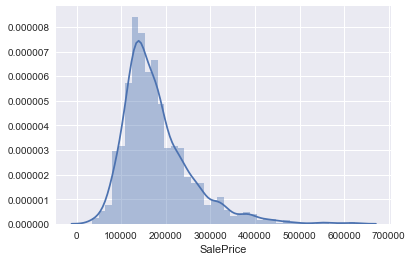

In [398]:
sns.distplot(Y_train1);

In [419]:
Y_train = np.log1p(Y_train1)


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


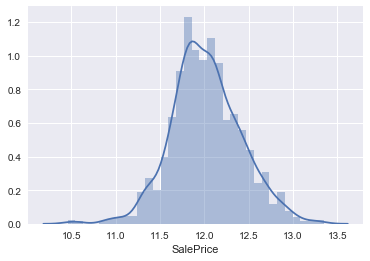

In [420]:
sns.distplot(Y_train);

## XGBoosting Regressor モデル

In [491]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.05, subsample=0.6, colsample_bytree=0.6)
xgb.fit(X_train1, Y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [492]:
from sklearn.model_selection import train_test_split
X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb = train_test_split(X_train1, Y_train, test_size=0.2)

In [493]:
xgb_pred = xgb.predict(X_test_xgb)

In [494]:
from sklearn.metrics import mean_squared_error
from math import sqrt
xgb_rmse = sqrt(mean_squared_error(Y_test_xgb, xgb_pred))
print(xgb_rmse)


0.02168129543360196


## LinearRegression モデル

In [425]:
#Linear RegressionはNAが扱えないので
X_train_ln = X_train1.fillna(0)
X_train_ln.head(10)

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,1,0,7,5,2003,2003,196.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,1,0,6,8,1976,1976,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,1,0,7,5,2001,2002,162.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,1,0,7,5,1915,1970,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,1,0,8,5,2000,2000,350.0,...,0,0,0,1,0,0,0,0,1,0
5,50,85.0,14115,1,0,5,5,1993,1995,0.0,...,0,0,0,1,0,0,0,0,1,0
6,20,75.0,10084,1,0,8,5,2004,2005,186.0,...,0,0,0,1,0,0,0,0,1,0
7,60,0.0,10382,1,0,7,6,1973,1973,240.0,...,0,0,0,1,0,0,0,0,1,0
8,50,51.0,6120,1,0,7,5,1931,1950,0.0,...,0,0,0,1,1,0,0,0,0,0
9,190,50.0,7420,1,0,5,6,1939,1950,0.0,...,0,0,0,1,0,0,0,0,1,0


In [426]:
Y_train_ln = Y_train.fillna(0)
Y_train_ln.head(10)

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
5    11.870607
6    12.634606
7    12.206078
8    11.774528
9    11.678448
Name: SalePrice, dtype: float64

### Linearようにまた分割するで

In [427]:
from sklearn.model_selection import train_test_split
X_train_ln, X_test_ln, Y_train_ln, Y_test_ln = train_test_split(X_train_ln, Y_train_ln, test_size=0.2)

In [428]:
X_test_ln = X_test.fillna(0)
X_test_ln.head(10)

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
419,20,65.0,8450,1,0,5,6,1968,1968,0.0,...,0,0,0,1,0,0,0,0,1,0
546,50,70.0,8737,1,0,6,7,1923,1950,0.0,...,0,0,0,1,0,0,0,0,1,0
1445,85,70.0,8400,1,0,6,5,1966,1966,0.0,...,0,0,0,1,0,0,0,0,1,0
130,60,88.0,14200,1,0,7,6,1966,1966,309.0,...,0,0,0,1,0,0,0,0,1,0
87,160,40.0,3951,1,0,6,5,2009,2009,76.0,...,0,1,0,0,0,0,0,0,0,1
592,20,60.0,6600,1,0,5,8,1982,2003,0.0,...,0,0,0,1,0,0,0,0,1,0
1098,50,50.0,6000,1,0,4,6,1936,1950,0.0,...,0,0,0,1,0,0,0,0,1,0
59,20,60.0,7200,1,0,5,7,1972,1972,0.0,...,0,0,0,1,0,0,0,0,1,0
1340,20,70.0,8294,1,0,4,5,1971,1971,0.0,...,0,0,0,1,0,0,0,0,1,0
809,75,90.0,8100,1,0,5,5,1898,1965,0.0,...,0,0,0,1,0,0,0,0,1,0


In [429]:
#一回目は線形モデルでやっていきます
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_ln, Y_train_ln)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [454]:
ln_pred = rfr.predict(X_test_ln)

In [455]:
from sklearn.metrics import mean_squared_error
from math import sqrt
ln_rmse = sqrt(mean_squared_error(Y_test_ln, ln_pred))
print(ln_rmse)

0.5536927993253272


### ちなみに、大事な特徴をランキングすると

In [413]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=15, max_features='auto')
rf.fit(X_train_ln, Y_train_ln)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Training done using Random Forest


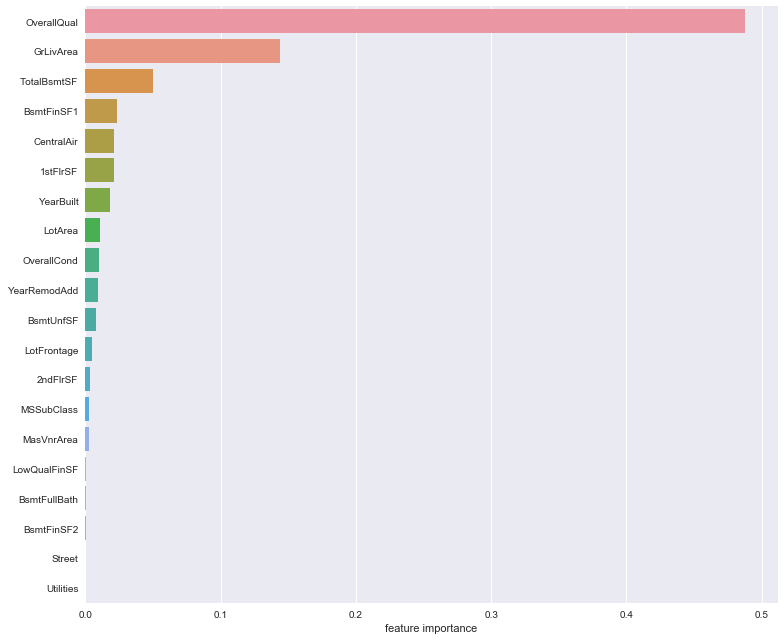

In [414]:
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_[:20])
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking][:20], y=X_train_ln.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

## Random Forest Regressor モデル

In [434]:
from sklearn.model_selection import train_test_split
X_train_rfr, X_test_rfr, Y_train_rfr, Y_test_rfr = train_test_split(X_train1, Y_train, test_size=0.2)

In [436]:
X_train_rfr = X_train_rfr.fillna(0)
Y_train_rfr = Y_train_rfr.fillna(0)
X_test_rfr = X_test_rfr.fillna(0)
Y_test_rfr = Y_test_rfr.fillna(0)

In [437]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train_rfr, Y_train_rfr)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [439]:
rfr_pred = rfr.predict(X_test_rfr)

In [442]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rfr_rmse = sqrt(mean_squared_error(Y_test_rfr, rfr_pred))
print(rfr_rmse)

0.1284078877308641


# まとめ

In [477]:
print(ln_rmse)
print(rfr_rmse)
print(xgb_rmse)

0.5536927993253272
0.1284078877308641
0.021608668454183834


# 課題

- XG Boostingでの結果については、過学習している可能性もある。
- やっていてわかったが、モデルを複数作る場合の変数の数が多くなり、もう少し整理品がら進めるようにならなければならない。